# Investigating RNNs and RL using the N-back cognitive task

**NMA 2023 Group 1 Project**

__Content creators:__  Aland Astudillo, Campbell Border, Disheng, Julia Yin, Koffivi, Rishabh Mallik, Shuwen Liu, Zelin Zhang

__Pod TA:__ Suryanarayanan Nagar Anthel Venkatesh

__Project Mentor:__

---
# Objective

-

-
---

# Project Design
---

# Setup

## Install Dependencies

In [1]:
# @title Install dependencies
%pip install jedi --quiet
%pip install --upgrade pip setuptools wheel --quiet
%pip install numpy==1.23.3 --quiet --ignore-installed
%pip install gymnasium --quiet
%pip install torch --quiet
%pip install matplotlib --quiet
%pip uninstall seaborn -y --quiet
%pip install seaborn --quiet
#!pip install trfl --quiet\n"

In [2]:
# @title Imports
import math
import numpy as np
from numpy.random import default_rng
import gymnasium as gym
from gymnasium import register
from gymnasium import spaces
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Figure settings

In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

## Datasets

- Human Connectome Project Working Memory (HCP WM) task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

- 1200 subjects, each subject experience 8 blocks of 2-back and 8 blocks of 0-back.

## N-back Tasks

Working memory is assessed using an N-back task in which participants are asked to monitor
sequentially presented pictures. Participants are presented with blocks of trials that consisted of
pictures of tools or faces. Within each run, the 2 different stimulus types are presented in
separate blocks. Also, within each run, ½ of the blocks use a 2-back working memory task and
½ use a 0-back working memory task (as a working memory comparison). Participants are
instructed to press a button for every picture. If the currently presented picture matches the
cued picture (0-Back) or the same picture that was presented two pictures before (2-Back),
subjects press one button with their right index finger. For non-matching pictures, participants
press a second button with their right middle finger. Two runs are performed, 16 blocks each,
with a bright fixation "rest" on dark background for 15 seconds between blocks.

- 2 back working memory task:

The second condition is a 2-Back condition. During such a block, the subject is presented with a sequence of 10 images and must respond if each image is identical to the one 2 positions earlier or not (figure, right). At the beginning of the block there is a cue screen informing the subject that the upcoming stimuli are part of the 2-Back protocol. The timing of the cue screen, the presentation of the 10 stimulus images and of the response interval are identical to that of the 0-Back condition.

- 0-back control memory task:

The first is a match-to-sample condition (termed in the following text as 0-Back) during which a cue “Target” image is presented at the beginning of a block and which the subject has been instructed to memorize. Then a sequence of 10 images is presented.

- Special modelling of images (we are probably not going to model this)

There are 2 different categories of images used in this experiment: images of faces and tools.
Each block contains images from a single category. Some of the images in the non-matched
trials have been characterized as “Lure”. These images have been selected so that they have
common features with the target image, but are still different. These trials as flagged as “Lure”.

https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf Page 72

---
## Implementation scheme

### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [4]:
# Test environment

register(
    id='NBack-v0',
    entry_point='nback_env_one_hot_encode:NBack',
)

env = gym.make(
    'NBack-v0',
    N = 2,
    num_trials=25,
    num_targets=7,
    rewards=(1, 0, 0, 0),
    num_obs=7,
    seed=42
    )

obs, info = env.reset()
print(env.sequence)
print(env.step_count, obs)
done = False
while not done:
  obs, reward, done, info  = env.step(0)
  if np.array_equal(obs[-1], obs[-3]):
    print(env.step_count, obs, "MATCH")
  else:
    print(env.step_count, obs)

[4 6 1 3 1 6 1 0 8 0 7 1 7 2 5 2 6 8 1 4 5 3 3 3 1 3 0]
0 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
1 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
2 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
3 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
4 [[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]] MATCH
5 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: int64
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.sequence to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sequence` for environment 

### Define a random agent

### Define a simple Q-learning agent

In [5]:
# Neural network representing the Q-function
class DQN(nn.Module):
  def __init__(self, obs_dim, num_actions, hidden_size=64, actv="ReLU()"):
    super().__init__()

    #self.num_obs = num_obs
    self.num_actions = num_actions
    self.hidden_size = hidden_size
    self.obs_dim = obs_dim
    self.rnn1 = nn.RNN(input_size=self.obs_dim, hidden_size=self.hidden_size,
                       num_layers=1, batch_first=True)
    self.rnn2 = nn.RNN(input_size=self.hidden_size, hidden_size=self.num_actions,
                       num_layers=1, batch_first=True)
    self.actv_layer = eval('nn.%s'%actv)

  def forward(self, x):
    #print(x.shape)
    x = torch.tensor(x, dtype=torch.float)
    x, _ = self.rnn1(x)
    x = self.actv_layer(x)
    out, _ = self.rnn2(x)
    #print(out.shape)
    out = out[...,-1,:]
    return out

In [6]:
!pip install torchsummary

In [7]:
pp = DQN(10, 2)

In [8]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, next_state, reward, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, next_state, reward, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        return np.stack(states), actions, np.stack(next_states), rewards, dones

    def __len__(self):
        return len(self.memory)

In [11]:
def train(model, memory, optimizer, criterion, batch_size, gamma, training=True):
    if len(memory) < batch_size:
        return np.array([0])
    states, actions, next_states, rewards, dones = memory.sample(batch_size)
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.LongTensor(actions))
    next_states = Variable(torch.FloatTensor(next_states))
    rewards = Variable(torch.FloatTensor(rewards))
    dones = Variable(torch.FloatTensor(dones))

    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = model(next_states).max(1)[0]

    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, target_q_values.detach())

    if training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.detach()


def exec_training(model, env, gamma=0.99, num_episodes = 100, training=True):

    # Create an instance of the replay memory
    capacity = 1000
    memory = ReplayMemory(capacity)

    # Set hyperparameters
    batch_size = 64
    lr = 0.001
    eps_max = 0.08
    eps_min = 0.01
    eps_step = 0.01

    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    tps = np.zeros(num_episodes)
    fps = np.zeros_like(tps)
    fns = np.zeros_like(tps)
    correct = np.zeros_like(tps)
    rewards_list = []
    loss_list = []

    # Training loop
    for episode in range(num_episodes):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        actions = []

        step_count = 1
        while not done:
            # Select an action using epsilon-greedy policy
            epsilon = max(eps_min, eps_max - eps_step * episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    #print(state)
                    q_values = model(torch.FloatTensor(state))

                    action = q_values.argmax().item()

            # Take the selected action and observe the next state and reward
            # next_state, reward, done, terminated, truncated = env.step(action)
            next_state, reward, done, info = env.step(action)

            # Store the transition in the replay memory
            memory.push(state, action, next_state, reward, done)

            # Move to the next state
            state = next_state
            total_reward += reward
            actions.append(action)

            # Train the model
            loss = train(model, memory, optimizer, criterion, batch_size, gamma, training)
            step_count += 1

            loss_list.append(loss.mean())

        rewards_list.append(total_reward)
        #print(np.array(actions).shape)
        actions = np.array(actions[2:])
        correct_actions = env.correct_actions
        tps[episode] = np.dot(actions, correct_actions) / sum(correct_actions)
        fps[episode] = np.dot(actions, 1 - correct_actions) / sum(1 - correct_actions)
        fns[episode] = np.dot(1 - actions, correct_actions) / sum(correct_actions)
        correct[episode] = sum(actions == correct_actions) / env.num_trials

        # Print the total reward for the episode
        # print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    return loss_list, rewards_list, tps, fps, fns, correct


In [12]:

# import gymnasium as gym
# from gymnasium import register

# env = gym.make(
#     'NBack-v0',
#     N = 2,
#     num_trials=25,
#     num_targets=5,
#     rewards=(1, 0, -1, -1),
#     num_obs=5,
#     seed=42
#     )

# # Create an instance of the DQN model
# input_size = env.observation_space.shape[0]
# output_size = env.action_space.n
# model = DQN(input_size, output_size, hidden_sizes = [64])

# observation, info = env.reset()
# loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = 500)

for episodes in [5, 10, 50, 100, 500]:

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=7,
        rewards=(1, 0, -1, -1),
        num_obs=7,
        seed=42
        )

    input_size = 10
    output_size = env.action_space.n
    model = DQN(obs_dim=input_size, num_actions=output_size, hidden_size = 64)

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = episodes)

    env = gym.make(
        'NBack-v0',
        N = 2,
        num_trials=25,
        num_targets=7,
        rewards=(1, 0, -1, -1),
        num_obs=7,
        seed=21
        )

    observation, info = env.reset()
    loss, rewards, tps, fps, fns, correct = exec_training(model=model, env=env, gamma=0, num_episodes = 500, training=False)

    print(episodes, correct.mean()*100)





<ipython-input-5-f92c0bfa1e09>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)


5 54.608000000000004
10 66.752
50 85.272
100 93.928
500 98.792


Prediction accuracy: 98.792


Text(0.5, 0, 'Episode % 1')

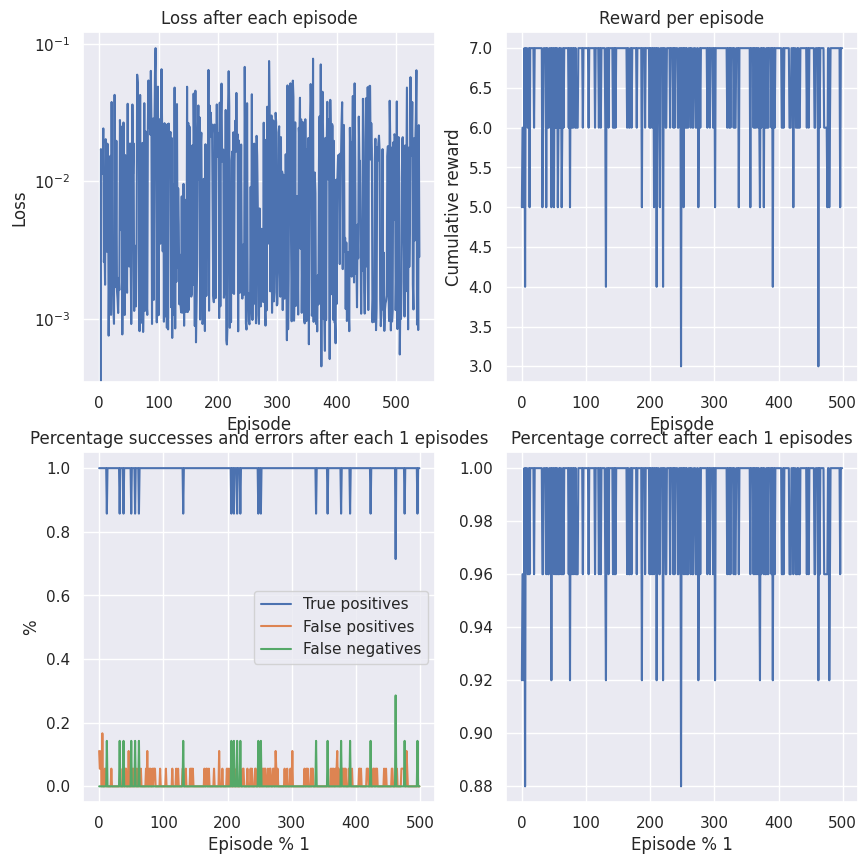

In [13]:
print(f"Prediction accuracy: {correct.mean() * 100}")

fig = plt.figure(figsize=(10, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(loss[::25], '-')
plt.title("Loss after each episode")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Episode")

# Reward
plt.subplot(2, 2, 2)
plt.plot(rewards, '-')
plt.title("Reward per episode")
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")

# TPs, FPs, FNs
step = 1
plt.subplot(2, 2, 3)
plt.plot(tps[::step])
plt.plot(fps[::step])
plt.plot(fns[::step])
plt.title(f"Percentage successes and errors after each {step} episodes")
plt.legend(["True positives", "False positives", "False negatives"])
plt.ylabel("%")
plt.xlabel(f"Episode % {step}")
fig.show()

# Percentage correct
step = 1
plt.subplot(2, 2, 4)
plt.plot(correct[::step])
plt.title(f"Percentage correct after each {step} episodes")
plt.xlabel(f"Episode % {step}")

### Define a Recurrent Deep Q-learning Agent (RDQN)

### Attempt to define a RNN in pytorch

# Section 4: Model(s)

In [ ]:
# Random agent
class RandomAgent(nn.Module):



In [ ]:
# RNN

class LayeredRNN(nn.Module)